In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data as data

import matplotlib.pyplot as plt

import seaborn as sns

import pytorch_lightning as pl

import numpy as np

print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.1.0+cu118
cuda


# Data

data_x.shape:  (1, 100, 3)
data_y.shape:  (1, 100, 1)


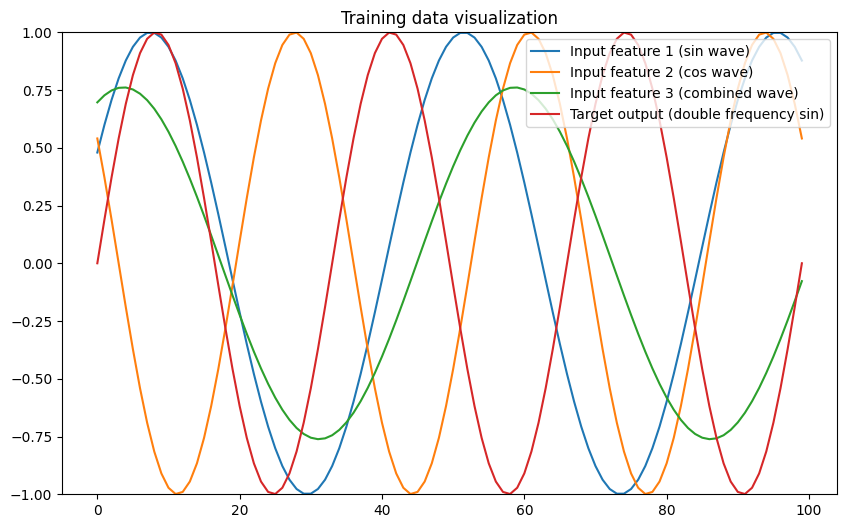

In [4]:
N = 100 # Length of the time-series

phase_shift_sin = 0.5  
frequency_sin = 1.5    

phase_shift_cos = 1.0 
frequency_cos = 2.0   

alpha = 0.7  # Weight for sine
beta = 0.3   # Weight for cosine
frequency_third = 1.2 
phase_shift_third = 0.75

data_x = np.stack([
    np.sin(frequency_sin * np.linspace(0, 3 * np.pi, N) + phase_shift_sin),
    np.cos(frequency_cos * np.linspace(0, 3 * np.pi, N) + phase_shift_cos),
    alpha * np.sin(frequency_third * np.linspace(0, 3 * np.pi, N) + phase_shift_third) + 
    beta * np.cos(frequency_third * np.linspace(0, 3 * np.pi, N) + phase_shift_third)
], axis=1)

data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension

data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)

print("data_x.shape: ", data_x.shape)
print("data_y.shape: ", data_y.shape)

data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)

# DataLoader for training
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(data_x[0, :, 0], label="Input feature 1 (sin wave)")
plt.plot(data_x[0, :, 1], label="Input feature 2 (cos wave)")
plt.plot(data_x[0, :, 2], label="Input feature 3 (combined wave)")
plt.plot(data_y[0, :, 0], label="Target output (double frequency sin)")
plt.ylim((-1, 1))
plt.title("Training data visualization")
plt.legend(loc="upper right")
plt.show()

# Model

In [7]:
class TimeSeriesNet(nn.Module):
    def __init__(self):
        super(TimeSeriesNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),  # Input layer corresponding to 3 features
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)   # Output layer corresponding to 1 target value per time step
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize the network
model = TimeSeriesNet()
print(model)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the network
def train(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs.squeeze(0))  # Remove batch dimension for single sample
            loss = criterion(outputs, targets.squeeze(0))  # Remove batch dimension for targets
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

TimeSeriesNet(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)


# Train

In [9]:
train(model, dataloader, epochs=50)

Epoch 1, Loss: 0.1645248383283615
Epoch 2, Loss: 0.146637424826622
Epoch 3, Loss: 0.13350412249565125
Epoch 4, Loss: 0.12514235079288483
Epoch 5, Loss: 0.1210474967956543
Epoch 6, Loss: 0.1219622865319252
Epoch 7, Loss: 0.126222163438797
Epoch 8, Loss: 0.12762218713760376
Epoch 9, Loss: 0.1228012815117836
Epoch 10, Loss: 0.11515232175588608
Epoch 11, Loss: 0.10807360708713531
Epoch 12, Loss: 0.10171099007129669
Epoch 13, Loss: 0.09636954963207245
Epoch 14, Loss: 0.09427047520875931
Epoch 15, Loss: 0.09545373916625977
Epoch 16, Loss: 0.0966063141822815
Epoch 17, Loss: 0.09618023782968521
Epoch 18, Loss: 0.09470659494400024
Epoch 19, Loss: 0.09224676340818405
Epoch 20, Loss: 0.08846406638622284
Epoch 21, Loss: 0.08459249138832092
Epoch 22, Loss: 0.08150779455900192
Epoch 23, Loss: 0.0789056271314621
Epoch 24, Loss: 0.07677387446165085
Epoch 25, Loss: 0.07516224682331085
Epoch 26, Loss: 0.07399648427963257
Epoch 27, Loss: 0.07291223853826523
Epoch 28, Loss: 0.07165351510047913
Epoch 29, L

# Results

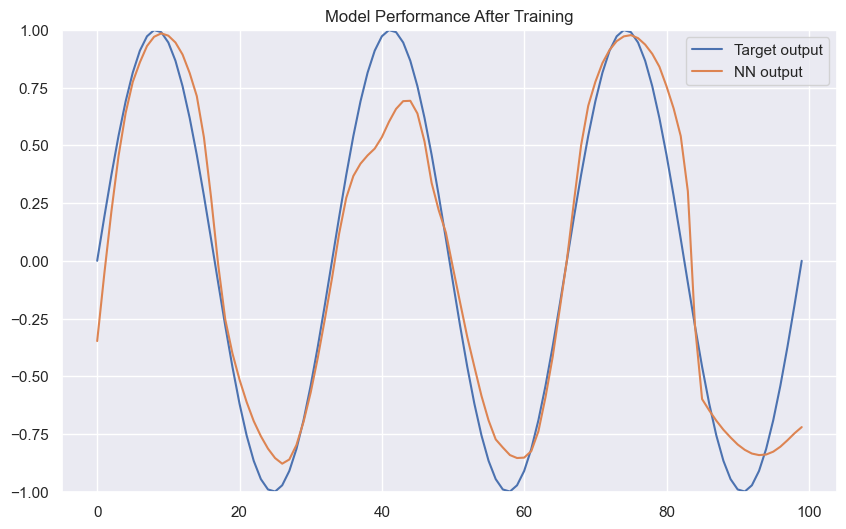

In [11]:
sns.set()
with torch.no_grad():
    prediction = model(data_x).squeeze(0).numpy()  
plt.figure(figsize=(10, 6))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[:, 0], label="NN output") 
plt.ylim((-1, 1))
plt.title("Model Performance After Training")
plt.legend(loc="upper right")
plt.show()